#Baseline
https://www.tensorflow.org/tutorials/load_data/images

#Imports

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Rescaling
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import optimizers
import numpy as np
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.utils import plot_model

!pip install pydicom
import numpy as np
import pydicom
from PIL import Image
import os

import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
!mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

#Baixando a DB


In [ ]:
!kaggle datasets download -d pedroamaro/smaller-rsnas-ds-ver-10


100% 7.24G/7.25G [02:49<00:00, 55.0MB/s]
100% 7.25G/7.25G [02:49<00:00, 46.0MB/s]


In [ ]:
!unzip /content/smaller-rsnas-ds-ver-10.zip
!rm /content/smaller-rsnas-ds-ver-10.zip

In [ ]:
print('Numero de imagens: NO')
!ls /content/small_rsna_ds/no | wc -l
print('Numero de imagens: YES')
!ls /content/small_rsna_ds/yes | wc -l

Numero de imagens: NO
30069
Numero de imagens: YES
4930


## Salvando como JPG

In [ ]:
!mkdir small_rsna_ds_as_jpg
!mkdir /content/small_rsna_ds_as_jpg/no
!mkdir /content/small_rsna_ds_as_jpg/yes

In [ ]:
def save_as_jpg(path, id, dest_folder):
  dcm = pydicom.dcmread(path)

  im = dcm.pixel_array.astype(float)

  rescaled_im = (np.maximum(im, 0)/im.max())*255.0
  final_im = np.uint8(rescaled_im)

  final_im = Image.fromarray(final_im)
  final_im.save(dest_folder+id+'.jpg')

In [ ]:
train_path = "/content/small_rsna_ds/yes/"
folder = os.listdir("/content/small_rsna_ds/yes/")
dest_folder = "/content/small_rsna_ds_as_jpg/yes/"

for id_ in folder:
  img_id = id_[:12]
  save_as_jpg(train_path + f"{id_}", img_id, dest_folder)

In [ ]:
train_path = "/content/small_rsna_ds/no/"
folder = os.listdir("/content/small_rsna_ds/no/")
dest_folder = "/content/small_rsna_ds_as_jpg/no/"

for id_ in folder:
  img_id = id_[:12]
  save_as_jpg(train_path + f"{id_}", img_id, dest_folder)

In [ ]:
print('Numero de imagens: NO')
!ls /content/small_rsna_ds_as_jpg/no/ | wc -l
print('Numero de imagens: YES')
!ls /content/small_rsna_ds_as_jpg/yes/ | wc -l

Numero de imagens: NO
30069
Numero de imagens: YES
4930


## Carregando o dataset

In [ ]:
train_data = image_dataset_from_directory(
    "/content/small_rsna_ds_as_jpg",
     labels='inferred',
     validation_split=0.25,
     subset="training",
     seed=123,
     batch_size = 64,
     color_mode = "grayscale"
     )

Found 34999 files belonging to 2 classes.
Using 26250 files for training.


In [ ]:
val_data = image_dataset_from_directory(
    "/content/small_rsna_ds_as_jpg",
     labels='inferred',
     validation_split=0.25,
     subset="validation",
     seed=123,
     batch_size = 64,
     color_mode = "grayscale"
)

Found 34999 files belonging to 2 classes.
Using 8749 files for validation.


In [ ]:
class_names = train_data.class_names

# Normalizando e Pegando o tamanho de entrada

In [ ]:
for image_batch, labels_batch in train_data:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 256, 256, 1)
(64,)


In [ ]:
normalization_layer = Rescaling(1./255)

normalized_data = train_data.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_data))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.98627454


#Criando o Modelo

In [ ]:
ins = image_batch.shape[1:]

model = Sequential()

model.add(Conv2D(32, (3,3), padding="same", activation="relu", input_shape=ins))

model.add(Conv2D(32, (3,3), padding="same", strides = (2,2), activation="relu"))

model.add(Conv2D(64, (3,3), padding="same", strides = (2,2), activation="relu"))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.2))

model.add(Dense(128, activation="relu"))

model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 dense (Dense)               (None, 32, 32, 128)       8320      
                                                        

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

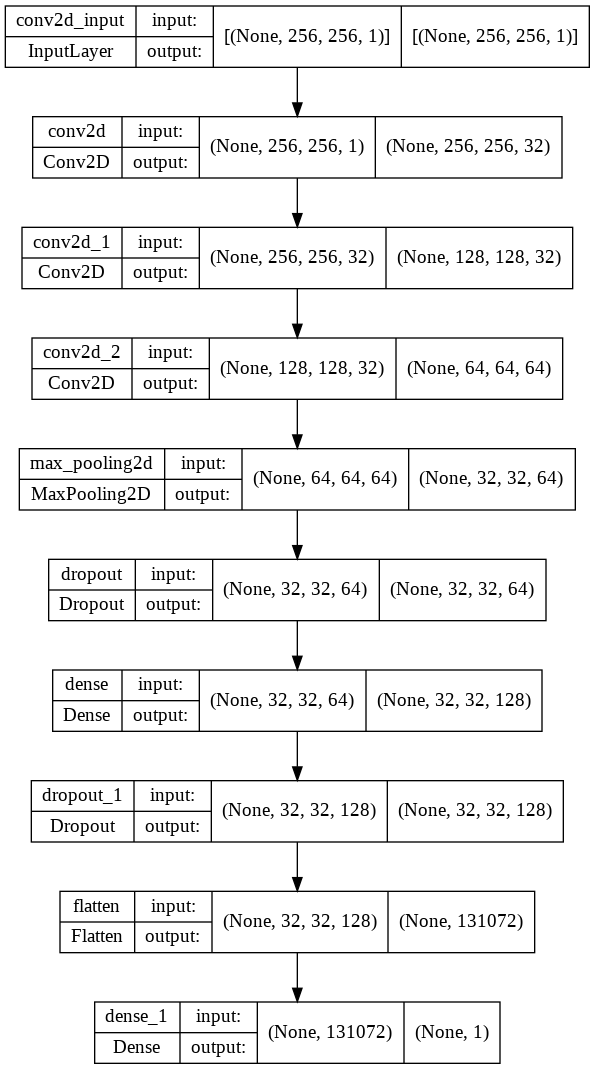

In [ ]:
plot_model(
    model,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False)

# Rodando com 5 epochs

In [ ]:
run_hist = model.fit(train_data, validation_data=val_data, epochs=5)

Epoch 1/5
411/411 [==============================] - 2141s 5s/step - loss: 0.5913 - accuracy: 0.8497 - val_loss: 0.3428 - val_accuracy: 0.8611
Epoch 2/5
411/411 [==============================] - 2016s 5s/step - loss: 0.3324 - accuracy: 0.8621 - val_loss: 0.3340 - val_accuracy: 0.8647
Epoch 3/5
411/411 [==============================] - 2026s 5s/step - loss: 0.3194 - accuracy: 0.8659 - val_loss: 0.3314 - val_accuracy: 0.8633
Epoch 4/5
411/411 [==============================] - 2076s 5s/step - loss: 0.3023 - accuracy: 0.8734 - val_loss: 0.3440 - val_accuracy: 0.8616
Epoch 5/5
411/411 [==============================] - 2056s 5s/step - loss: 0.2871 - accuracy: 0.8794 - val_loss: 0.3373 - val_accuracy: 0.8585


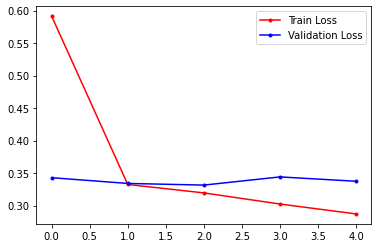

In [ ]:
fig, ax = plt.subplots()
ax.plot(run_hist.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()

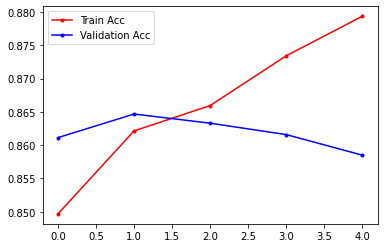

In [ ]:
fig, ax = plt.subplots()
ax.plot(run_hist.history["accuracy"],'r', marker='.', label="Train Acc")
ax.plot(run_hist.history["val_accuracy"],'b', marker='.', label="Validation Acc")
ax.legend()

# Rodando com 12 epochs

In [ ]:
run_hist = model.fit(train_data, validation_data=val_data, epochs=12)

Epoch 1/12
411/411 [==============================] - 2181s 5s/step - loss: 0.5028 - accuracy: 0.8536 - val_loss: 0.3446 - val_accuracy: 0.8599
Epoch 2/12
411/411 [==============================] - 2040s 5s/step - loss: 0.3291 - accuracy: 0.8626 - val_loss: 0.3319 - val_accuracy: 0.8631
Epoch 3/12
411/411 [==============================] - 2033s 5s/step - loss: 0.3126 - accuracy: 0.8674 - val_loss: 0.3267 - val_accuracy: 0.8635
Epoch 4/12
411/411 [==============================] - 2037s 5s/step - loss: 0.2917 - accuracy: 0.8760 - val_loss: 0.3323 - val_accuracy: 0.8659
Epoch 5/12
411/411 [==============================] - 2035s 5s/step - loss: 0.2781 - accuracy: 0.8826 - val_loss: 0.3366 - val_accuracy: 0.8635
Epoch 6/12
411/411 [==============================] - 2038s 5s/step - loss: 0.2553 - accuracy: 0.8925 - val_loss: 0.3340 - val_accuracy: 0.8697
Epoch 7/12
411/411 [==============================] - 2050s 5s/step - loss: 0.2426 - accuracy: 0.8969 - val_loss: 0.3670 - val_accuracy:

In [ ]:
fig, ax = plt.subplots()
ax.plot(run_hist.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()

In [ ]:
fig, ax = plt.subplots()
ax.plot(run_hist.history["accuracy"],'r', marker='.', label="Train Acc")
ax.plot(run_hist.history["val_accuracy"],'b', marker='.', label="Validation Acc")
ax.legend()

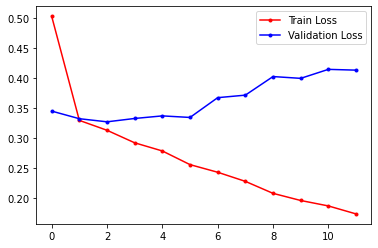

In [ ]:
train_loss = [0.5028, 0.3291, 0.3126, 0.2917, 0.2781, 0.2553, 0.2426, 0.2274, 0.2074, 0.1955, 0.1864, 0.1731]
val_loss = [0.3446, 0.3319, 0.3267, 0.3323, 0.3366, 0.3340, 0.3670, 0.3712, 0.4022, 0.3992, 0.4142, 0.4129]

fig, ax = plt.subplots()
ax.plot(train_loss,'r', marker='.', label="Train Loss")
ax.plot(val_loss,'b', marker='.', label="Validation Loss")
ax.legend()

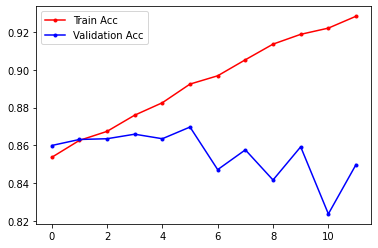

In [ ]:
train_acc = [0.8536, 0.8626, 0.8674, 0.8760, 0.8826, 0.8925, 0.8969, 0.9054, 0.9137, 0.9189, 0.9222, 0.9285]
val_acc = [0.8599, 0.8631, 0.8635, 0.8659, 0.8635, 0.8697, 0.8471, 0.8576, 0.8416, 0.8592, 0.8236, 0.8498]
fig, ax = plt.subplots()
ax.plot(train_acc, 'r', marker='.', label="Train Acc")
ax.plot(val_acc, 'b', marker='.', label="Validation Acc")
ax.legend()

#Rodando com 20 epochs

In [ ]:
run_hist = model.fit(train_data, validation_data=val_data, epochs=20)

In [ ]:
fig, ax = plt.subplots()
ax.plot(run_hist.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()

In [ ]:
fig, ax = plt.subplots()
ax.plot(run_hist.history["accuracy"],'r', marker='.', label="Train Acc")
ax.plot(run_hist.history["val_accuracy"],'b', marker='.', label="Validation Acc")
ax.legend()